Pre-trained model loaded from my_save_dir/models/701.pth
0
1
2
3
4
5
6
7
8
9
{'image_tensor': tensor([[[[0.0044, 0.0062, 0.0075,  ..., 0.0056, 0.0068, 0.0046],
          [0.0084, 0.0067, 0.0053,  ..., 0.0086, 0.0094, 0.0070],
          [0.0088, 0.0047, 0.0037,  ..., 0.0110, 0.0105, 0.0087],
          ...,
          [0.0072, 0.0063, 0.0068,  ..., 0.0030, 0.0063, 0.0077],
          [0.0061, 0.0054, 0.0058,  ..., 0.0039, 0.0071, 0.0080],
          [0.0055, 0.0060, 0.0073,  ..., 0.0071, 0.0080, 0.0067]]],


        [[[0.0035, 0.0030, 0.0035,  ..., 0.0032, 0.0033, 0.0021],
          [0.0035, 0.0026, 0.0030,  ..., 0.0071, 0.0057, 0.0041],
          [0.0053, 0.0037, 0.0028,  ..., 0.0111, 0.0076, 0.0062],
          ...,
          [0.0089, 0.0069, 0.0073,  ..., 0.0087, 0.0060, 0.0066],
          [0.0084, 0.0043, 0.0028,  ..., 0.0091, 0.0068, 0.0061],
          [0.0115, 0.0060, 0.0019,  ..., 0.0084, 0.0077, 0.0067]]],


        [[[0.0028, 0.0041, 0.0094,  ..., 0.0028, 0.0016, 0.0022],
          

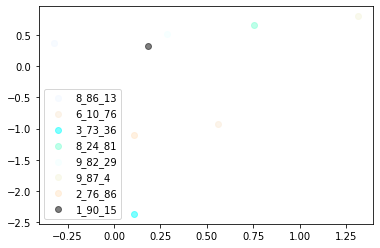

{'tensor': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'binary_label': ['8_6_58', '7_87_86', '9_50_46', '1_61_70']}
{'tensor': tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 2., 0., 0.]]), 'binary_label': ['3_52_47', '3_60_86', '9_3_58', '2_88_82']}
{'tensor': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'binary_label': ['0_86_50', '9_16_21', '8_17_37', '2_61_87']}
{'tensor': tensor([[0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 2.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'binary_label': ['5_90_83', '0_66_12', '9_47_82', '9_8_85']}
{'tensor': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0.,

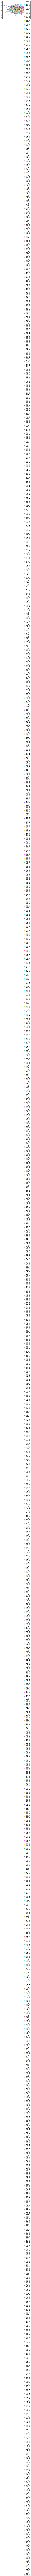

In [10]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from final_dataloader import RNA_Dataset
from final_dataloader import ImageDataset
from model_from_master import FC_Autoencoder, FC_Classifier, VAE, FC_VAE, Simple_Classifier

import os
import argparse
import numpy as np
import imageio

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors

torch.manual_seed(1)

#============ PARSE ARGUMENTS =============

#parse arguments
options = argparse.ArgumentParser()

# save and directory options
options.add_argument('-sd', '--save-dir', action="store", dest="save_dir", default="my_save_dir/rna")
options.add_argument('--save-freq', action="store", dest="save_freq", default=100, type=int)
options.add_argument('--pretrained-file', action="store", default="my_save_dir/models/701.pth") #last epoch of train_ae.py

# training parameters
options.add_argument('-bs', '--batch-size', action="store", dest="batch_size", default=4, type=int) #32
options.add_argument('-w', '--num-workers', action="store", dest="num_workers", default=10, type=int) 
options.add_argument('-lrAE', '--learning-rate-AE', action="store", dest="learning_rate_AE", default=1e-4, type=float)
options.add_argument('-lrD', '--learning-rate-D', action="store", dest="learning_rate_D", default=1e-4, type=float)
options.add_argument('-se', '--max-epochs', action="store", dest="max_epochs", default=10, type=int) # 800
options.add_argument('-wd', '--weight-decay', action="store", dest="weight_decay", default=0, type=float)
options.add_argument('--train-imagenet', action="store_true")
options.add_argument('--conditional', action="store_true")
options.add_argument('--conditional-adv', action="store_true")

# hyperparameters
options.add_argument('--alpha', action="store", default=0.1, type=float)
options.add_argument('--beta', action="store", default=1., type=float)
options.add_argument('--lamb', action="store", default=0.00000001, type=float)
options.add_argument('--latent-dims', action="store", default=128, type=int)

# gpu options
options.add_argument('-gpu', '--use-gpu', action="store_false", dest="use_gpu")

args, unknown = options.parse_known_args()

if not torch.cuda.is_available():
    args.use_gpu = False

os.makedirs(args.save_dir, exist_ok=True)

#============= TRAINING INITIALIZATION ==============

# initialize autoencoder
netRNA = FC_VAE(n_input=15814, nz=args.latent_dims)

netImage = VAE(latent_variable_size=args.latent_dims, batchnorm=True)
netImage.load_state_dict(torch.load(args.pretrained_file))
print("Pre-trained model loaded from %s" % args.pretrained_file)


if args.use_gpu:
    netRNA.cuda()
    netImage.cuda()
    

# load data
genomics_dataset = RNA_Dataset(datadir="data_folder/my_data/")
image_dataset = ImageDataset(datadir="data_folder/my_data//", mode='test') #test

image_loader = DataLoader(image_dataset, batch_size=args.batch_size, drop_last=True, shuffle=True)
genomics_loader = DataLoader(genomics_dataset, batch_size=args.batch_size, drop_last=True, shuffle=True)

# setup optimizer
opt_netRNA = optim.Adam(list(netRNA.parameters()), lr=args.learning_rate_AE)
opt_netImage = optim.Adam(list(netImage.parameters()), lr=args.learning_rate_AE)


# loss criteria
criterion_reconstruct = nn.MSELoss()
criterion_classify = nn.CrossEntropyLoss()

# setup logger
with open(os.path.join(args.save_dir, 'log.txt'), 'w') as f:
    print(args, file=f)
    print(netRNA, file=f)
    print(netImage, file=f)
    

# define helper train functions

def compute_KL_loss(mu, logvar):
    if args.lamb>0:
        KLloss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return args.lamb * KLloss
    return 0

def train_autoencoders(rna_inputs, image_inputs, rna_class_labels=None, image_class_labels=None):
   
    netRNA.train()
    if args.train_imagenet:
        netImage.train()
    else:
        netImage.eval()
    
    
    # process input data
    rna_inputs, image_inputs = Variable(rna_inputs), Variable(image_inputs)

    if args.use_gpu:
        rna_inputs, image_inputs = rna_inputs.cuda(), image_inputs.cuda()

    # reset parameter gradients
    netRNA.zero_grad()

    # forward pass
    rna_recon, rna_latents, rna_mu, rna_logvar = netRNA(rna_inputs)
    image_recon, image_latents, image_mu, image_logvar = netImage(image_inputs)
    
    '''
    if args.use_gpu:
        rna_labels, image_labels = rna_labels.cuda(), image_labels.cuda()
    '''    

    # compute losses
    rna_recon_loss = criterion_reconstruct(rna_inputs, rna_recon)
    image_recon_loss = criterion_reconstruct(image_inputs, image_recon)
    kl_loss = compute_KL_loss(rna_mu, rna_logvar) + compute_KL_loss(image_mu, image_logvar)
    loss = args.alpha*(rna_recon_loss + image_recon_loss) + kl_loss

    # backpropagate and update model
    loss.backward()
    opt_netRNA.step()
    

    if args.train_imagenet:
        opt_netImage.step()

    summary_stats = {'rna_recon_loss': rna_recon_loss.item(), 'image_recon_loss': image_recon_loss.item()}

    return summary_stats


def accuracy(output, target):
    pred = output.argmax(dim=1).view(-1)
    correct = pred.eq(target.view(-1)).float().sum().item()
    return correct

def generate_image(epoch):
    img_dir = os.path.join(args.save_dir, "images")
    os.makedirs(img_dir, exist_ok=True)
    netRNA.eval()
    netImage.eval()

    for i in range(5):
        samples = genomics_loader.dataset[np.random.randint(30)]
        rna_inputs = samples['tensor']
        rna_inputs = Variable(rna_inputs.unsqueeze(0))
        samples = image_loader.dataset[np.random.randint(10)]
        image_inputs = samples['image_tensor']
        image_inputs = Variable(image_inputs.unsqueeze(0))
 
        if torch.cuda.is_available():
            rna_inputs = rna_inputs.cuda()
            image_inputs = image_inputs.cuda()
 
        _, rna_latents, _, _ = netRNA(rna_inputs)
        recon_inputs = netImage.decode(rna_latents)
        imageio.imwrite(os.path.join(img_dir, "epoch_%s_trans_%s.jpg" % (epoch, i)), np.uint8(recon_inputs.cpu().data.view(64,64).numpy()*255))
        recon_images, _, _, _ = netImage(image_inputs)
        imageio.imwrite(os.path.join(img_dir, "epoch_%s_recon_%s.jpg" % (epoch, i)), np.uint8(recon_images.cpu().data.view(64,64).numpy()*255))
 
### main training loop
for epoch in range(args.max_epochs):
    print(epoch)

    if epoch % args.save_freq == 0:
        generate_image(epoch)

    
    recon_rna_loss = 0
    recon_image_loss = 0

    n_rna_correct = 0
    n_rna_total = 0
    
    

    for idx, (rna_samples, image_samples) in enumerate(zip(genomics_loader, image_loader)):
        rna_inputs = rna_samples['tensor']
        image_inputs = image_samples['image_tensor']

        
        out = train_autoencoders(rna_inputs, image_inputs)

        recon_rna_loss += out['rna_recon_loss']
        recon_image_loss += out['image_recon_loss']


    with open(os.path.join(args.save_dir, 'log.txt'), 'a') as f:
        print('Epoch: ', epoch, ', rna recon loss: %.8f' % float(recon_rna_loss), ', image recon loss: %.8f' % float(recon_image_loss), file=f)

    # save model
    if epoch % args.save_freq == 0:
        torch.save(netRNA.cpu().state_dict(), os.path.join(args.save_dir,"netRNA_%s.pth" % epoch))
        torch.save(netImage.cpu().state_dict(), os.path.join(args.save_dir,"netImage_%s.pth" % epoch))
        

    if args.use_gpu:
        netRNA.cuda()
        netImage.cuda()

def plot_latent_space_with_labels_image(data_loader, model):
    model = model.cuda()
    '''
    labels = []
    for i, dict in enumerate(data_loader):
        label = dict["label"]
        labels = labels + label
    
    d = {i:[] for i in labels}
    '''
    d = {}
    with torch.no_grad():
        for i, dict in enumerate(data_loader):
            print(dict)
            
            images = dict["image_tensor"]
            labels1 = dict["label"]
            
            embedding = model.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d[name] = embedding[i].to("cpu").numpy()
                
    # print(d)
    colors = list(mcolors.CSS4_COLORS.items())*10
    for i,j in zip(list(d.keys()), range(len(list(d.keys())))):
        print(d[i])
        # d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][0], d[i][1],
            color=colors[j][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()


plot_latent_space_with_labels_image(
    data_loader=image_loader,
    model=netImage.cuda())

plt.legend()
plt.show()

def plot_latent_space_with_labels_rna(data_loader, model):
    model = model.cuda()
    
    d = {}
    with torch.no_grad():
        for i, dict in enumerate(data_loader):
            print(dict)
            
            images = dict["tensor"]
            labels1 = dict["binary_label"]
            
            embedding = model.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d[name] = embedding[i].to("cpu").numpy()
                
    # print(d)
    colors = list(mcolors.CSS4_COLORS.items())*50
    for i,j in zip(list(d.keys()), range(len(list(d.keys())))):
        # d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][0], d[i][1],
            color=colors[j][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

plot_latent_space_with_labels_rna(
    data_loader=genomics_loader,
    model=netRNA.cuda())

plt.legend()
plt.show()

In [108]:
from sklearn.neighbors import NearestNeighbors

# now I want to get both rna latent space and image latent space coordinates
# first check if there are matches in the data used - should be 1000 but i might not be using all

def determine_latent_overlap(data1, data2, model1, model2):

    # model 1 - rna
    model1 = model1.cuda()
    
    d1 = {}
    with torch.no_grad():
        for i, dict in enumerate(data1):
            
            images = dict["tensor"]
            labels1 = dict["binary_label"]
            
            embedding = model1.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d1[name] = embedding[i].to("cpu").numpy()
    
    
    # model 2 - images
    d2 = {}
    with torch.no_grad():
        for i, dict in enumerate(data2):
            
            images = dict["image_tensor"]
            labels1 = dict["label"]
            
            embedding = model2.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d2[name] = embedding[i].to("cpu").numpy()
    
    
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())

    shared = d1_keys.intersection(d2_keys)

    # print(shared)

    # for those in intersection find knn
    # ideally this would include the real labels

    image_latents = list(d2.values())
    image_latents_array = np.stack(image_latents, axis=0)

    for point in shared:

        # d1 is rna latent point from shared, looking at nearest neighbours in image as smaller
        knn_matrix =np.vstack((d1[point], image_latents_array))
        knn = NearestNeighbors(n_neighbors=2)
        knn.fit(knn_matrix)
        neigh_coords = knn.kneighbors([knn_matrix[0]], return_distance=False)
        print(neigh_coords)

        neigh_labels = []
        for index in neigh_coords[0]:
          if index != 0:
              neigh = next(key for key, value in d2.items() if knn_matrix[index] in value)
            #   neigh = list(d2.keys())[list(d2.values()).index(knn_matrix[index])]
              neigh_labels.append(neigh)
              print(point, neigh)



        
    return neigh
    

In [109]:
determine_latent_overlap(genomics_loader, image_loader, netRNA.cuda(), netImage.cuda())

[[0 2]]
8_15_72 9_87_4
[[0 8]]
5_89_83 8_86_13
[[0 3]]
2_76_86 9_82_29
[[0 8]]
1_90_15 8_86_13
[[0 3]]
9_82_29 9_82_29
[[0 3]]
6_10_76 9_82_29
[[0 3]]
8_86_13 9_82_29
[[0 6]]
9_87_4 1_90_15


'1_90_15'